In [215]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

from IPython.display import display

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics 

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

In [216]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [217]:
# list of explanatory variables
features = df.columns.tolist()
features

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [218]:
# # of parents / children aboard the Titanic
parch_unique = df['Parch'].unique()
np.sort(parch_unique)

array([0, 1, 2, 3, 4, 5, 6])

In [219]:
# # of siblings / spouses aboard the Titanic
sibsp_unique = df['SibSp'].unique()
np.sort(sibsp_unique)

array([0, 1, 2, 3, 4, 5, 8])

In [220]:
sex_unique = df['Sex'].unique()
np.sort(sex_unique)

array(['female', 'male'], dtype=object)

In [221]:
df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

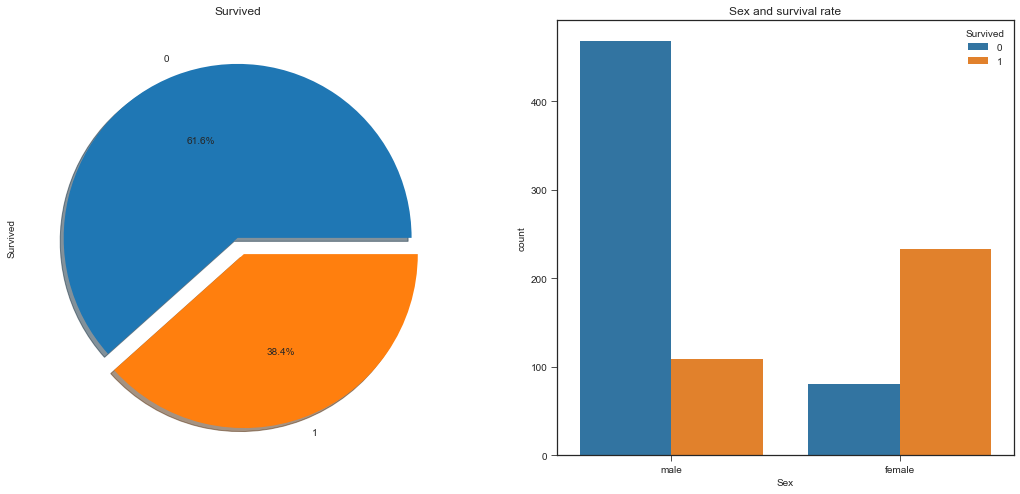

In [222]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('Survived')

sns.countplot(x='Sex', hue='Survived', data=df, ax=ax[1])
ax[1].set_title('Sex and survival rate')

plt.show()

Average age on board: : 30.0


Text(0.5, 0, 'Age')

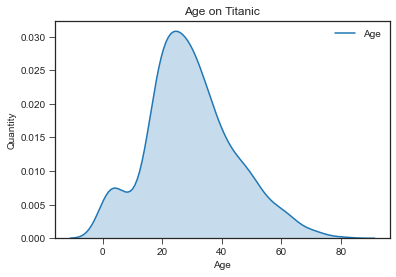

In [223]:
print("Average age on board: :", np.round(df['Age'].mean(),0))
sns.kdeplot(data=df['Age'], shade=True)
plt.title("Age on Titanic")
plt.ylabel('Quantity')
plt.xlabel('Age')

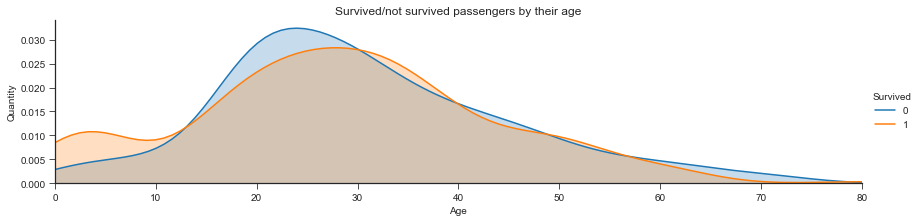

In [224]:
w = sns.FacetGrid(df, hue="Survived",aspect=4)
w.map(sns.kdeplot,'Age',shade= True)
w.set(xlim=(0, df['Age'].max()))
plt.title("Survived/not survived passengers by their age")
plt.ylabel('Quantity')
w.add_legend()

Text(0.5, 1.0, 'Age and survived')

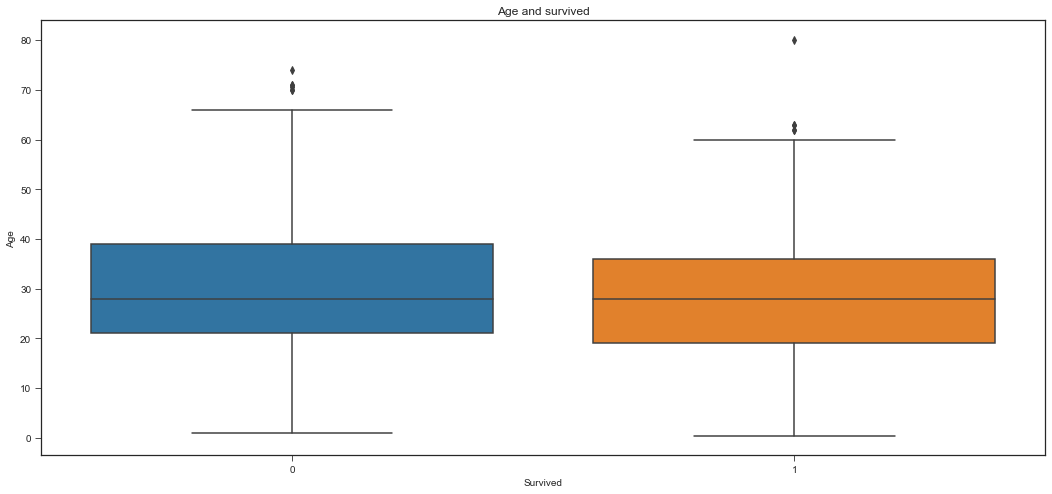

In [225]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title("Age and survived")

The average age of the survivors and non-survivors is comparable.

In [226]:
df.groupby(['Survived'])['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

50% of survivors are younger than non-survivors. More elderly people were in the group of the deceased. On the other hand, youth and being a young child did not guarantee survival.

Text(0.5, 1.0, 'Fare and survived')

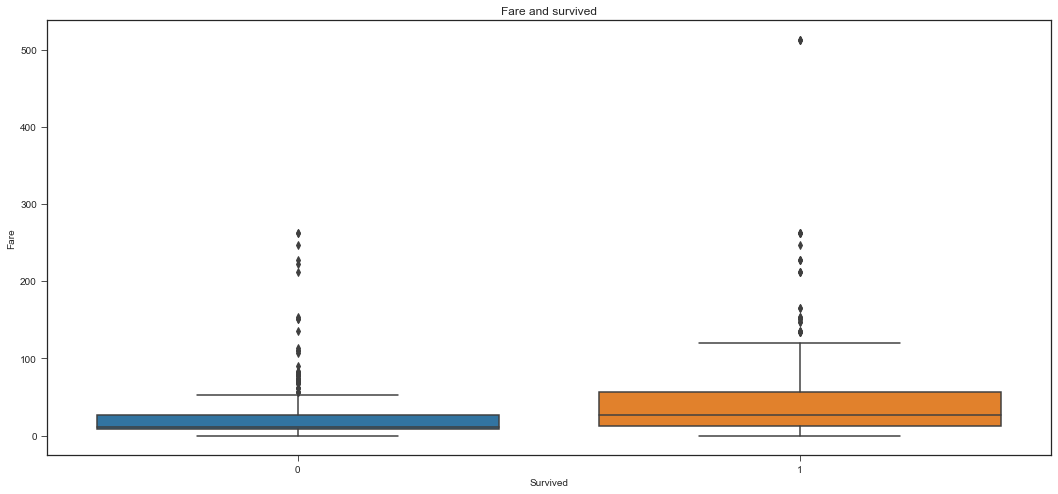

In [227]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df)

plt.title("Fare and survived")

Remove outlier from df['Fare']

Text(0.5, 1.0, 'Fare and survived')

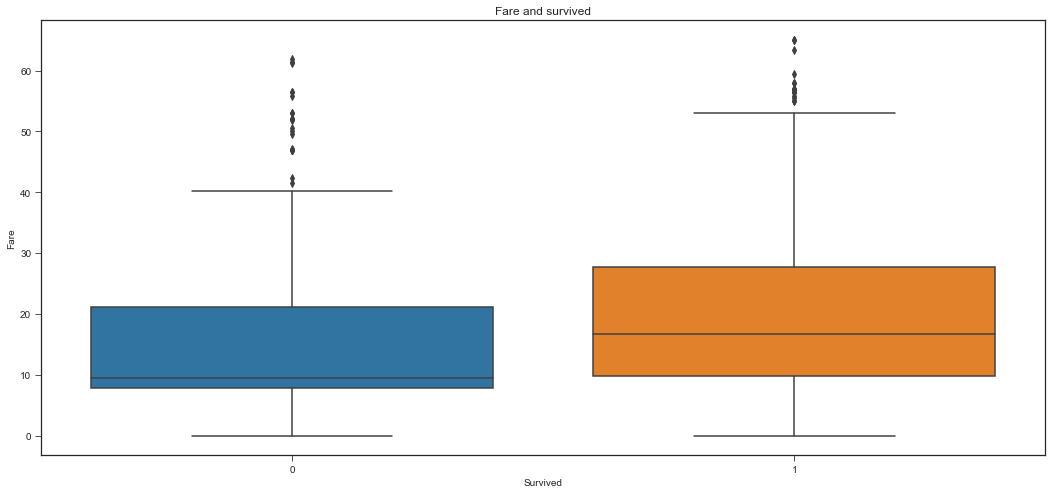

In [228]:
df3 = pd.read_csv("train.csv")

Q1 = df3['Fare'].quantile(0.25)
Q3 = df3['Fare'].quantile(0.75)
IQR = Q3-Q1 
fence_low  = Q1-1.5*IQR
fence_high = Q3+1.5*IQR
mask = (df3['Fare'] > fence_high) | (df3['Fare'] < fence_low)
df3.loc[mask, 'Fare'] = np.nan
    
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df3)
plt.title("Fare and survived")

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


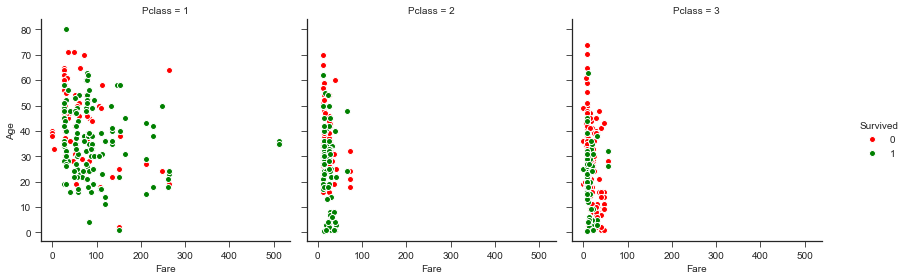

In [229]:
g = sns.FacetGrid(df, hue="Survived", col="Pclass", margin_titles=True,palette={1:"green", 0:"red"}, size=4, aspect=1)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

Text(0.5, 0.98, 'Survival by Gender , Age and Fare')

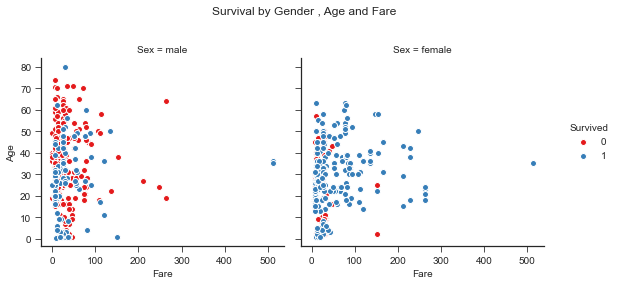

In [230]:
g = sns.FacetGrid(df, hue="Survived", col="Sex", margin_titles=True, palette="Set1", size=4, aspect=1)

g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)

g.fig.suptitle('Survival by Gender , Age and Fare')

## RANDOM FOREST

In [231]:
from sklearn import preprocessing

In [232]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [233]:
df['Cabin'] = df['Cabin'].fillna('no_data')

In [234]:
df['Cabin'].head()

0    no_data
1        C85
2    no_data
3       C123
4    no_data
Name: Cabin, dtype: object

In [235]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64


In [236]:
print('how many full data about cabin: ', (df['Cabin']).count() - 687)
print('how many all data about cabin: ', (df['Cabin']).count())

how many full data about cabin:  204
how many all data about cabin:  891


In [237]:
df['Cabin'] = df['Cabin'].str[:1]
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,n,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,n,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


In [238]:
#on board there was no T level
j=0
for cabin in df['Cabin']:
    #print(j, ' ',cabin)    
    if cabin == 'T':
        df['Cabin'][j] = 'n'
        print(j)
    j += 1

339


<ipython-input-238-3a46a43c695a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cabin'][j] = 'n'


In [239]:
df['Cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

In [240]:
average_age = df.Age.mean()

In [241]:
df['Age'] = df['Age'].fillna(average_age)

In [242]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64


In [243]:
#drop all NaN from 'Embarked'
df = df.dropna()

In [244]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [245]:
df_train = pd.read_csv("train.csv")
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### WORK ON TRAIN SET

In [246]:
# get the number of missing data points per column
missing_values_count_train = df_train.isnull().sum()
print(missing_values_count_train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [247]:
df_train['Cabin'] = df_train['Cabin'].fillna('no_data')

In [248]:
df_train['Cabin'] = df_train['Cabin'].str[:1]
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,n,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,n,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


In [249]:
#on board there was no T level
j=0
for cabin in df_train['Cabin']:  
    if cabin == 'T':
        df_train['Cabin'][j] = 'n'
        print(j)
    j += 1

339


<ipython-input-249-33eecdc7c6bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Cabin'][j] = 'n'


In [250]:
df_train['Cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

In [251]:
average_age_train = df_train.Age.mean()

In [252]:
df_train['Age'] = df_train['Age'].fillna(average_age_train)

In [253]:
missing_values_count_train = df_train.isnull().sum()
print(missing_values_count_train)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64


In [254]:
#drop all NaN from 'Embarked'
df_train = df_train.dropna()

In [255]:
missing_values_count_train = df_train.isnull().sum()
print(missing_values_count_train)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [267]:
target = 'Survived'
numFeatures = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
catFeatures = ['Sex', 'Cabin', 'Embarked']

features = numFeatures+catFeatures
print(features)

numFeatures_train = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
catFeatures_train = ['Sex', 'Cabin', 'Embarked']

features_train = numFeatures_train+catFeatures_train
print(features_train)

y = df_train["Survived"]
X = pd.get_dummies(df_train[features_train])
X_test = pd.get_dummies(df[features])

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Cabin', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Cabin', 'Embarked']


In [270]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df.PassengerId, 'Survived': predictions})
#output.to_csv('random_forest.csv', index=False)
print("Tree done!")

Tree done!


In [286]:
testResults = []
model.fit(X, y)
preds = model.predict(X_test)

testScore = roc_auc_score(df[target]==1, preds)
    
testResults.append(testScore)
        
print("AUC:", testScore)

AUC: 0.8208480660023574


In [287]:
for k in [10, 25, 50, 100, 200, 500, 1000]:
    model = RandomForestClassifier(n_estimators=k, max_depth=5, random_state=1)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k: ', k, "AUC:", testScore)

k:  10 AUC: 0.8216838101360763
k:  25 AUC: 0.8159434265509483
k:  50 AUC: 0.8162943319404264
k:  100 AUC: 0.8208480660023574
k:  200 AUC: 0.8268723882995821
k:  500 AUC: 0.8272232936890603
k:  1000 AUC: 0.8365396978463517


In [296]:
for k in [500, 1000, 2000, 10000]:
    model = RandomForestClassifier(n_estimators=k, max_depth=5, random_state=1)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k: ', k, "AUC:", testScore)

k:  500 AUC: 0.8272232936890603
k:  1000 AUC: 0.8365396978463517
k:  2000 AUC: 0.8350691096110575
k:  10000 AUC: 0.8343672988321011


n_estimators=1000

In [297]:
for k in range(6,42,2):
    model = RandomForestClassifier(n_estimators=1000, max_depth=k)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k:', k, "-->  AUC:", testScore)

k: 6 -->  AUC: 0.8517384549448194
k: 8 -->  AUC: 0.8951623272259723
k: 10 -->  AUC: 0.9300385728061716
k: 12 -->  AUC: 0.954620700739312
k: 14 -->  AUC: 0.9628843887281688
k: 16 -->  AUC: 0.9702373299046394
k: 18 -->  AUC: 0.9775902710811102
k: 20 -->  AUC: 0.9834726240222865
k: 22 -->  AUC: 0.9834726240222865
k: 24 -->  AUC: 0.9834726240222865
k: 26 -->  AUC: 0.9834726240222865
k: 28 -->  AUC: 0.9834726240222865
k: 30 -->  AUC: 0.9834726240222865
k: 32 -->  AUC: 0.9840324654451945
k: 34 -->  AUC: 0.9834726240222865
k: 36 -->  AUC: 0.9840324654451945
k: 38 -->  AUC: 0.9834726240222865
k: 40 -->  AUC: 0.9840324654451945


max_depth=26

In [304]:
for k in range(2, 20, 2):
    model = RandomForestClassifier(n_estimators=1000, max_depth=26, max_features=k)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k:', k, "-->  AUC:", testScore)

k: 2 -->  AUC: 0.9834726240222865
k: 4 -->  AUC: 0.9845923068681024
k: 6 -->  AUC: 0.9840324654451945
k: 8 -->  AUC: 0.9840324654451945
k: 10 -->  AUC: 0.9840324654451945
k: 12 -->  AUC: 0.9845923068681024
k: 14 -->  AUC: 0.9840324654451945
k: 16 -->  AUC: 0.9840324654451945
k: 18 -->  AUC: 0.9840324654451945


In [301]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    model = RandomForestClassifier(n_estimators=1000, max_depth=26, max_features=4, 
                                   min_samples_split=k)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k:', k, "-->  AUC:", testScore)

k: 2 -->  AUC: 0.9834726240222865
k: 4 -->  AUC: 0.9473347262402229
k: 6 -->  AUC: 0.9186917389906782
k: 8 -->  AUC: 0.9012536162005786
k: 10 -->  AUC: 0.8903996571306118
k: 15 -->  AUC: 0.8704382299367834
k: 20 -->  AUC: 0.8568520304296582
k: 30 -->  AUC: 0.8388540662166506


In [305]:
for k in [1, 2, 4, 6, 8]:
    model = RandomForestClassifier(n_estimators=1000, max_depth=26,
                                   max_features=4, min_samples_split=2,
                                   min_samples_leaf=k)
    model.fit(X, y)
    predictions = model.predict(X_test)
    testScore = roc_auc_score(df[target]==1, predictions)
    testResults.append(testScore)
    print('k:', k, "-->  AUC:", testScore)

k: 1 -->  AUC: 0.9834726240222865
k: 2 -->  AUC: 0.8994321225758064
k: 4 -->  AUC: 0.8500589306760955
k: 6 -->  AUC: 0.8337404907318119
k: 8 -->  AUC: 0.8282090431801137


In [310]:
model = RandomForestClassifier(n_estimators=1000, max_depth=26,
                                   max_features=4, min_samples_split=2,
                                   min_samples_leaf=1)
model.fit(X, y)
predictions = model.predict(X_test)
testScore = roc_auc_score(df[target]==1, predictions)
testResults.append(testScore)
print("AUC:", testScore)

AUC: 0.9840324654451945
